In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [3]:
import numpy as np 
from matplotlib import pyplot as plt
from vowpalwabbit import pyvw
import time

In [84]:
np.random.seed(0)
num_users = 5 
num_ads = 10
reward_table = {user: np.random.choice(10, size=num_ads) for user in range(num_users)}

In [5]:
class UniformlyRandom:
    def __init__(self, num_actions):
        """
        num_actions: number of actions (in this demo, it is equal to the number of ads)
        """
        self.num_actions = num_actions 

    def choose_action(self, context):
        """
        return a chosen action and action-probabilities
        """
        return np.random.choice(self.num_actions), [1 / self.num_actions] * self.num_actions

    def update(self, cb_sample):
        """
        UniformlyRandom is a stateless policy, which means it does not update itself
        based on the past rewards revelaed by it.

        (parameters)
        cb_sample: a tuple of (context, chosen action, reward revealed)
        """
        pass

In [6]:
class EpsilonGreedy:
    def __init__(self, num_actions, num_contexts, epsilon=0.1):
        """
        This is a CB verision of epsilon greedy

        (parameters)
        num_actions: number of actions (= number of ads)
        num_contexts: number of contexts (= number of users)
        epsilon: this policy chooeses a random action with epsilon probability 

        (Stored values)
        self.num_actions = num_actions 
        self.num_contexts = num_contexts
        self.num_actions_chosen: keep track of how many times each action is chosen for each context
        self.sum_rewards: keep track of the total reward of each action for each context

        The reason why self.num_actions_chosen is initialized with np.ones instead of np.zeros is
        to prevent division by zero in the function choose_action (line 68) 
        when an action has never been chosen so far for a given context.
        """
        self.num_actions = num_actions 
        self.num_contexts = num_contexts
        self.num_actions_chosen = {context: np.ones(num_actions) for context in range(num_contexts)}
        self.sum_rewards = {context: np.zeros(num_actions) for context in range(num_contexts)}
        self.epsilon = epsilon

    def choose_action(self, context):
        """
        return a chosen action and its probability
        """
        # Check which action is the best action 
        # The best action is the action that has the highest total reward for a given context
        best_action = np.argmax(self.sum_rewards[context] / self.num_actions_chosen[context])

        # Get action probabilities based on the best action
        # there is a (epsilon + epsilon/num_actions) probability of choosing the best action.
        # there is a (epsilon/num_actions) probability of choosing any other action
        action_probabilities = [self.epsilon / self.num_actions] * self.num_actions
        action_probabilities[best_action] += 1 - self.epsilon

        # Sample an action
        chosen_action = np.random.choice(self.num_actions, p=action_probabilities)

        # Record the number of times the chosen action is chosen
        self.num_actions_chosen[context][chosen_action] += 1

        return chosen_action, action_probabilities

    def update(self, cb_sample):
        """
        EpsilonGreedy is a stateful policy, which means it does update itself
        based on the past rewards revelaed by it.
        Thus, update function is necessary.

        (parameters)
        cb_sample: a tuple of (context, chosen action, reward revealed)
        """
        context, chosen_action, reward_revealed = cb_sample

        self.sum_rewards[context][chosen_action] += reward_revealed

In [7]:
class StochasticPolicy:
    def __init__(self, num_actions):
        self.num_actions = num_actions

    def choose_action(self, context):
        '''
        Always chooses the first ad
        '''
        return (0, [1] + [0] * (self.num_actions - 1))

    def update(self, cb_sample):
        pass

In [8]:
class DeterministicPolicy:
    def __init__(self, num_actions):
        self.num_actions = num_actions

    def choose_action(self, context):
        '''
        Always chooses from ratio of 1:2:1:2:1:2 ... 
        '''
        p = np.ones(self.num_actions)
        for i in range(self.num_actions):
            if i % 2 == 1:
                p[i] = 2
        p = p/np.sum(p)
        chosen_action = np.random.choice(self.num_actions, p=p)
        
        return chosen_action, p

    def update(self, cb_sample):
        pass

In [22]:
class IPS:
    def __init__(self):
        self.estimates = list()
        self.name = 'IPS'

    def get_estimate(self, old_probability, new_probability, reward):
        """
        Append the IPS estimate of a single sample to self.estimates.
        You should implement this function
        """
        self.estimates.append((new_probability / old_probability) * reward)
        

    def evaluation(self, num_samples):
        """
        Get the mean of num_samples number of IPS estimates
        """
        return np.mean(self.estimates[:num_samples])

    def bootstrap(self, num_samples, bootstrap_num, true_performance):
        bootstrap_estimates = [self.evaluation(num_samples)]
        
        new_list = self.estimates[:num_samples]

        for _ in range(1, bootstrap_num):
            bootstrap_list = np.random.choice(new_list, size=num_samples)
            bootstrap_estimates.append(np.mean(bootstrap_list))

        errors_list = [abs(true_performance - estimate) / true_performance for estimate in bootstrap_estimates]

        return np.mean(errors_list), np.std(errors_list)

In [30]:
class DR:
    def __init__(self, lr):
        self.lr = lr # learning rate
        self.estimates = list()
        self.Q = np.zeros((num_users, num_ads)) # Q-learning table
        self.name = f'DR_{lr}'

    def update_Q(self, context, action, reward):
        "Implement a function that updates Q"
        old = self.Q[context, action]
        new = old + self.lr * (reward + 0*max(self.Q[context]) 
                - old)
        self.Q[context, action] = new

    def get_estimate(self, context, action, reward, old_probability, new_probabilities):
        """
        Append the DR estimate of a single sample to self.estimates.
        You should implement this function
        """
        r_hat_x_v = np.matmul(np.array(new_probabilities), self.Q[context])
        estimate = r_hat_x_v + (new_probabilities[action]/old_probability
                                *(reward - self.Q[context, action]))
        self.estimates.append(estimate)
        self.update_Q(context, action, reward)


    def evaluation(self, num_samples):
        """
        Get the mean of num_samples number of IPS estimates
        """
        return np.mean(self.estimates[:num_samples])

    def bootstrap(self, num_samples, bootstrap_num, true_performance):
        bootstrap_estimates = [self.evaluation(num_samples)]
        
        new_list = self.estimates[:num_samples]

        for _ in range(1, bootstrap_num):
            bootstrap_list = np.random.choice(new_list, size=num_samples)
            bootstrap_estimates.append(np.mean(bootstrap_list))

        errors_list = [abs(true_performance - estimate) / true_performance for estimate in bootstrap_estimates]

        return np.mean(errors_list), np.std(errors_list)

In [41]:

class DRVW:
    def __init__(self, default_model="--power_t 0.0 -q ca --quiet"):
        self.estimates = list()
        self.name = f'DRVW'
        self.model = pyvw.vw(default_model)

    def vw_format(self, context, action, reward=None):
        """
        This function takes in a context and an action 
        and return a VW format string that contains the given inputs
        """

        if reward is not None:
            return f"{reward} |c context{context} |a action{action}"
        else: 
            return f"|c context{context} |a action{action}"

    def update_Q(self, context, action, reward):
         "Implement a function that updates Q"
         self.model.learn(self.vw_format(context, action, reward))

    def get_Q(self, context, action):
        "Implement a function that retrieves a Q value from the VW model"
        return self.model.predict(self.vw_format(context, action))

    def get_estimate(self, context, action, reward, old_probability, new_probabilities):
        """
        Append the DR estimate of a single sample to self.estimates.
        You should implement this function
        """
        r_hat_x_v = np.matmul(np.array(new_probabilities), np.array([self.get_Q(context, i) 
                                                          for i in range(num_ads)]))
        estimate = r_hat_x_v + (new_probabilities[action]/old_probability
                                *(reward - self.get_Q(context, action)))
        self.estimates.append(estimate)
        self.update_Q(context, action, reward)
        

    def evaluation(self, num_samples):
        """
        Get the mean of num_samples number of IPS estimates
        """
        return np.mean(self.estimates[:num_samples])

    def bootstrap(self, num_samples, bootstrap_num, true_performance):
        bootstrap_estimates = [self.evaluation(num_samples)]
        
        new_list = self.estimates[:num_samples]

        for _ in range(1, bootstrap_num):
            bootstrap_list = np.random.choice(new_list, size=num_samples)
            bootstrap_estimates.append(np.mean(bootstrap_list))

        errors_list = [abs(true_performance - estimate) / true_performance for estimate in bootstrap_estimates]

        return np.mean(errors_list), np.std(errors_list)

In [42]:
uni_ran = UniformlyRandom(num_ads)
eps_greedy = EpsilonGreedy(num_ads, num_users, epsilon=epsilon)
sto = StochasticPolicy(num_ads)
det = DeterministicPolicy(num_ads)

In [70]:
%%capture
from tqdm import tqdm_notebook as tqdm

In [85]:
epsilon = 0.01 # epsilon is a tunable parameter
# Start the demo
num_samples = 1000000 # total number of samples. Feel free to change this if you want to
new_policy_true_rewards = list() # Keep track of true rewards revealed by the new policy

# Implement the demo as specified by the comments below
old_policy = eps_greedy 
new_policy = uni_ran
ips_estimator = IPS()
dr_estimator1 = DR(lr=1)
dr_estimator2 = DR(lr=0.1)
dr_estimator3 = DR(lr=0.01)
drvw_estimator = DRVW()

for sample_index in tqdm(range(num_samples)): 
    # Context (user) revealed
    user = np.random.choice(num_users)

    # The old policy chooses an action
    old_chosen_action, old_probabilities = old_policy.choose_action(user)

    # The reward of the action chosen by the old policy is revealed
    reward = reward_table[user][old_chosen_action]

    # The new policy chooses an action
    new_chosen_action, new_probabilities = new_policy.choose_action(user)

    # Record the reward revealed by the new policy to get the true performance of the new policy
    new_policy_true_rewards.append(reward_table[user][new_chosen_action])

    # Store the CB sample in trace for evaluation
    ips_estimator.get_estimate(old_probabilities[old_chosen_action], new_probabilities[old_chosen_action],
                              reward)
    # Get DR estimate
    dr_estimator1.get_estimate(user, old_chosen_action, reward, old_probabilities[old_chosen_action], new_probabilities)
    dr_estimator2.get_estimate(user, old_chosen_action, reward, old_probabilities[old_chosen_action], new_probabilities)
    dr_estimator3.get_estimate(user, old_chosen_action, reward, old_probabilities[old_chosen_action], new_probabilities)
    drvw_estimator.get_estimate(user, old_chosen_action, reward, old_probabilities[old_chosen_action], new_probabilities)
    # Update the old policy if needed
    old_policy.update((user, old_chosen_action, reward))

true_performance = np.mean(new_policy_true_rewards)

# List the error of each estimator
estimators = [ips_estimator, dr_estimator1, dr_estimator2, dr_estimator3, drvw_estimator]
bootstrap_num = 20

means = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]
stds = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5)]

for j, estimator in enumerate(estimators):
    print(estimator.name)
    for i in range(2, 7):
        num_samples = int(10**i)
        mean, std = estimator.bootstrap(num_samples, bootstrap_num, true_performance)
        means[j][i-2] = mean
        stds[j][i-2] = std
        print(f"(num_samples: {num_samples}): (mean: {mean} / std: {std})")
    print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



IPS
(num_samples: 100): (mean: 0.6407157511176899 / std: 0.5293859911935999)
(num_samples: 1000): (mean: 0.3174306592815036 / std: 0.1978472345860374)
(num_samples: 10000): (mean: 0.09324952688899532 / std: 0.05790311615396456)
(num_samples: 100000): (mean: 0.026143505945340685 / std: 0.02497999947087137)
(num_samples: 1000000): (mean: 0.015951918516130405 / std: 0.009608253060182688)

DR_1
(num_samples: 100): (mean: 0.49672799777513843 / std: 0.36834158137319906)
(num_samples: 1000): (mean: 0.25820526793932885 / std: 0.17828426100704048)
(num_samples: 10000): (mean: 0.08988847474043117 / std: 0.05147702359128832)
(num_samples: 100000): (mean: 0.0076951676752752204 / std: 0.005906275367914946)
(num_samples: 1000000): (mean: 0.0011340028651474754 / std: 0.0006453574565239947)

DR_0.1
(num_samples: 100): (mean: 0.5599031439781699 / std: 0.5177899780530487)
(num_samples: 1000): (mean: 0.3255981600487323 / std: 0.15019726173337605)
(num_samples: 10000): (mean: 0.061030339288290936 / std: 

In [86]:
# Table that shows how accurate the DM estimate of the DR_0.1 estimator is
for i in range(num_users):
  for j in range(num_ads):
    reward = reward_table[i][j]

    print(f"{(i,j)}: {reward} / {dr_estimator2.Q[i, j]} / {reward - dr_estimator2.Q[i, j]}")
  print()

(0, 0): 5 / 4.999999998633358 / 1.366641910749422e-09
(0, 1): 0 / 0.0 / 0.0
(0, 2): 3 / 2.999999999088906 / 9.110938670175983e-10
(0, 3): 3 / 2.999999992506012 / 7.493988096740622e-09
(0, 4): 7 / 6.999999895150309 / 1.0484969070745365e-07
(0, 5): 9 / 8.999999999999993 / 7.105427357601002e-15
(0, 6): 3 / 2.9999999970966758 / 2.9033242476828036e-09
(0, 7): 5 / 4.999999978848107 / 2.1151892681814388e-08
(0, 8): 2 / 1.9999999998610476 / 1.3895240513761564e-10
(0, 9): 4 / 3.9999999994770725 / 5.229274790963245e-10

(1, 0): 7 / 6.999999976013754 / 2.398624587840459e-08
(1, 1): 6 / 5.999999991149751 / 8.8502494222098e-09
(1, 2): 8 / 7.999999998565356 / 1.4346444032753425e-09
(1, 3): 8 / 7.9999999999999964 / 3.552713678800501e-15
(1, 4): 1 / 0.9999999969160541 / 3.083945876447558e-09
(1, 5): 6 / 5.99999994103553 / 5.8964469751288107e-08
(1, 6): 7 / 6.9999999939030175 / 6.096982474446122e-09
(1, 7): 7 / 6.999999963441174 / 3.655882618858186e-08
(1, 8): 8 / 7.99999999944419 / 5.558096205504626e-

In [87]:
# Table that shows how accurate the DM estimate of the DRVW estimator is
for i in range(num_users):
  for j in range(num_ads):
    reward = reward_table[i][j]

    print(f"{(i,j)}: {reward} / {drvw_estimator.get_Q(i, j)} / {reward - drvw_estimator.get_Q(i, j)}")
  print()

(0, 0): 5 / 5.0 / 0.0
(0, 1): 0 / 0.0 / 0.0
(0, 2): 3 / 2.999999761581421 / 2.384185791015625e-07
(0, 3): 3 / 2.999999761581421 / 2.384185791015625e-07
(0, 4): 7 / 7.0 / 0.0
(0, 5): 9 / 9.0 / 0.0
(0, 6): 3 / 3.0 / 0.0
(0, 7): 5 / 5.0 / 0.0
(0, 8): 2 / 2.0 / 0.0
(0, 9): 4 / 3.999999761581421 / 2.384185791015625e-07

(1, 0): 7 / 7.0 / 0.0
(1, 1): 6 / 6.0 / 0.0
(1, 2): 8 / 8.0 / 0.0
(1, 3): 8 / 8.0 / 0.0
(1, 4): 1 / 1.0 / 0.0
(1, 5): 6 / 6.0 / 0.0
(1, 6): 7 / 7.0 / 0.0
(1, 7): 7 / 7.0 / 0.0
(1, 8): 8 / 7.999999523162842 / 4.76837158203125e-07
(1, 9): 1 / 0.9999992847442627 / 7.152557373046875e-07

(2, 0): 5 / 5.0 / 0.0
(2, 1): 9 / 9.0 / 0.0
(2, 2): 8 / 8.0 / 0.0
(2, 3): 9 / 9.0 / 0.0
(2, 4): 4 / 4.0 / 0.0
(2, 5): 3 / 3.000000238418579 / -2.384185791015625e-07
(2, 6): 0 / 2.384185791015625e-07 / -2.384185791015625e-07
(2, 7): 3 / 3.0 / 0.0
(2, 8): 5 / 5.0 / 0.0
(2, 9): 0 / 0.0 / 0.0

(3, 0): 2 / 2.0 / 0.0
(3, 1): 3 / 3.0 / 0.0
(3, 2): 8 / 8.0 / 0.0
(3, 3): 1 / 1.0 / 0.0
(3, 4): 3 / 3.0 / 0

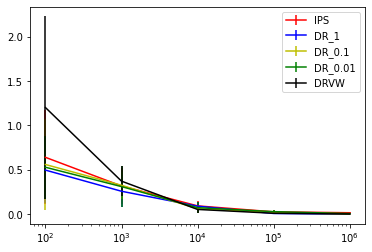

In [88]:
color = ['r', 'b', 'y', 'g', 'k']
x = np.array([10]*5)**range(2, 7)
for i in range(5):
  plt.errorbar(x, means[i], yerr=stds[i], color=color[i])
plt.xscale('log')
plt.legend(['IPS', 'DR_1', 'DR_0.1', 'DR_0.01', 'DRVW'])
plt.show()